In [33]:
import imp, table_loading
imp.reload(table_loading)

<module 'table_loading' from '/home/btingle/table_loading.py'>

In [34]:
from table_loading import *

In [35]:
tbl = Table.read(f'/home/btingle/tbl_G328', format='fits')
tbl.add_index('SPICY')

# Multi-geometry fitting

In [36]:
spicyid = 31415
fieldid = 'G328'

In [37]:
rownum = tbl.loc_indices[spicyid]

In [38]:
flx, error, valid = get_data_to_fit(rownum, tbl, filters=filternames+["ALMA-IMF_1mm", "ALMA-IMF_3mm"])
apertures = [2, 2, 2, 2, 2, 2.4, 2.4, 2.4, 2.4, 6, 3, 3, 3, 3, 3, 3, 3]*u.arcsec

In [9]:
# Treating the ALMA points as upper limits for experimental purposes, especially with 31415valid[15] = 3
error[15] = 0.997
valid[16] = 3
error[16] = 0.997

In [39]:
fits = {geom:
        fit_a_source(data=flx,#.quantity,
             error=error,#.quantity,
             valid=valid, aperture_size=apertures,#.quantity,
             filters=filternames+["ALMA-IMF_1mm", "ALMA-IMF_3mm"],#.quantity,
                   av_range=[5,40],
                   distance_range=[2300,2500]*u.pc,
                     geometry=geom,
                  )
        for geom in geometries}

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02
   Number of distances :  3

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Y.fits


   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Z.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.J.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.H.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Ks.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I1.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I2.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I3.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I4.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s--

In [40]:
from astropy.table import QTable
datatable = QTable([filternames+["ALMA-IMF_1mm", "ALMA-IMF_3mm"], flx * u.mJy, error * u.mJy, valid], names=['band','flux','error','valid'])

In [41]:
datatable

band,flux,error,valid
,mJy,mJy,
str18,float64,float64,int64
Paranal/VISTA.Y,0.06253620849609375,0.997,3
Paranal/VISTA.Z,0.042862478995436715,0.997,3
Paranal/VISTA.J,0.0737300980836153,0.997,3
Paranal/VISTA.H,0.07741640727701288,0.997,3
Paranal/VISTA.Ks,0.39754951000213623,0.03647243231534958,1
Spitzer/IRAC.I1,28.05614471435547,1.5701144933700562,1
Spitzer/IRAC.I2,88.74459838867188,6.350530624389648,1
Spitzer/IRAC.I3,202.45408630371094,9.286884307861328,1


# Plotting

In [42]:
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['font.size'] = 16

In [43]:
%run plot_fit_mod.py

# Analysis

In [44]:
{geom: np.nanmin(fitinfo.chi2) for geom, fitinfo in fits.items()}

{'s---s-i': <Quantity 2533550.13442646>,
 's---smi': <Quantity 3097918.67822483>,
 'sp--s-i': <Quantity 2956.72726281>,
 'sp--h-i': <Quantity 5731.59749488>,
 's-p-smi': <Quantity 129612.87378639>,
 's-p-hmi': <Quantity 2417.83511909>,
 's-pbsmi': <Quantity 1026.91218209>,
 's-pbhmi': <Quantity 891.22427269>,
 's-u-smi': <Quantity 13084.48811434>,
 's-u-hmi': <Quantity 2445.93817101>,
 's-ubsmi': <Quantity 6086.46502977>,
 'spu-smi': <Quantity 2787.60159725>,
 'spu-hmi': <Quantity 1489.59393451>,
 'spubsmi': <Quantity 1201.37354431>,
 'spubhmi': <Quantity 1293.75571452>}

In [48]:
okgeo = []
chi2limit = 2000

for geom in geometries:
    # we impose an _absolute_ chi^2 limit (the fitter uses a _relative_, delta chi2 limit)
    print(f"{geom}: {np.nanmin(fits[geom].chi2):12.1f}")
    if np.nanmin(fits[geom].chi2) < chi2limit:
        okgeo.append(geom)
        
print(okgeo)

s---s-i:    2533550.1
s---smi:    3097918.7
sp--s-i:       2956.7
sp--h-i:       5731.6
s---smi:    3097918.7
s-p-smi:     129612.9
s-p-hmi:       2417.8
s-pbsmi:       1026.9
s-pbhmi:        891.2
s-u-smi:      13084.5
s-u-hmi:       2445.9
s-ubsmi:       6086.5
spu-smi:       2787.6
spu-hmi:       1489.6
spubsmi:       1201.4
spubhmi:       1293.8
['s-pbsmi', 's-pbhmi', 'spu-hmi', 'spubsmi', 'spubhmi']


In [49]:
deltachi2limit = 200

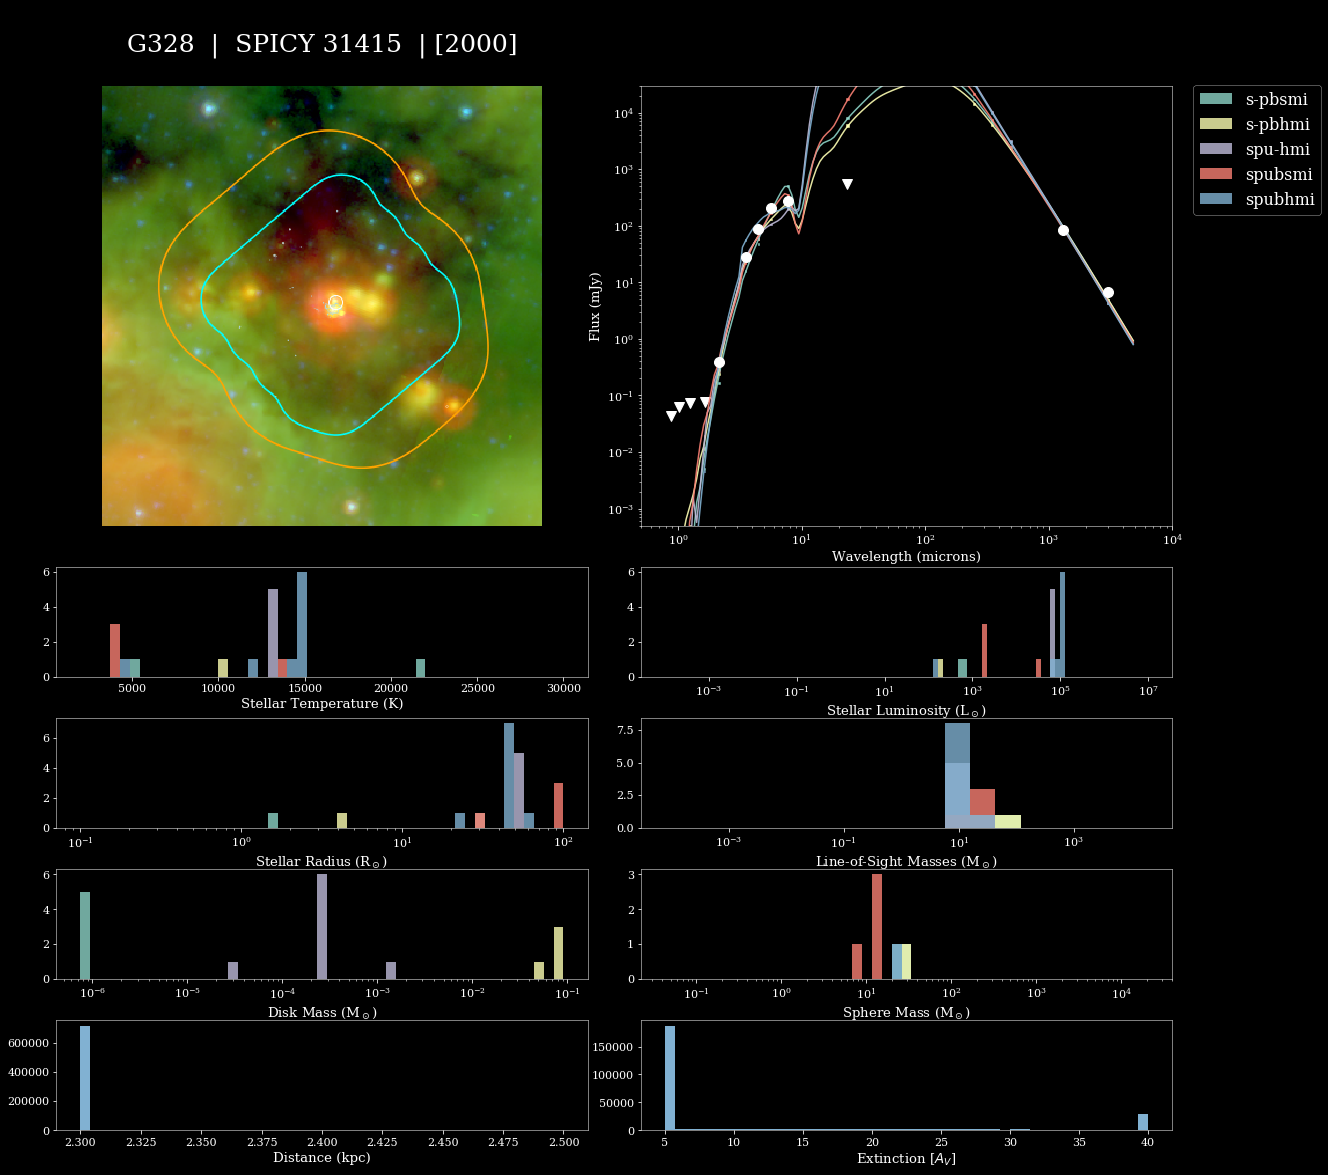

In [53]:
plot_fit(fits, okgeo, deltachi2limit=deltachi2limit, chi2limit=chi2limit, fieldid='G328', spicyid=spicyid)